In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

sns.set_style('whitegrid')

In [175]:
# Import maximum demands per locality

demand = pd.read_csv('demand.csv')

demand = (demand
          .set_index(pd.to_datetime(demand['Date']))
          .drop('Date', axis = 1)
          )

In [176]:
# Import day-ahead market prices
dam = pd.read_csv('dam.csv')

dam['Date'] = pd.to_datetime(dam['Date'])

dam = (dam
       .set_index(dam['Date']) # pd.to_datetime(dam['Date'])
       .drop('Date', axis = 1)
       )

dam = dam.reset_index().rename(columns = {'Date': 'date_old'})
dam['date_new'] = dam['date_old'] - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)

dam = dam.drop('date_old', axis = 1).rename(columns = {'date_new': 'Date'}).set_index('Date')

dam.columns = ['nyca_dam', 'nyc_dam', 'li_dam', 'gj_dam']

In [177]:
# Import fuel prices
fuels = pd.read_csv('fuels.csv')
fuels = (fuels
         .set_index(pd.to_datetime(fuels['Date']))
         .drop('Date', axis = 1)
        )

In [178]:
# Import capacity prices
cap = pd.read_csv('cap.csv')
cap = (cap
       .set_index(pd.to_datetime(cap['Date'], format = '%b-%y'))
       .drop('Date', axis = 1)
       )
cap.columns = ['nyca_icap', 'gj_icap', 'nyc_icap', 'li_icap']

#cap.plot()

In [179]:
# Generation capacities

locs = ['GJ', 'LI', 'NYC']

gen = {}

for loc in locs:
    gen[loc] = pd.read_csv(f'../data\Generating_Capacity_{loc}_11-23.csv')
    gen[loc] = (gen[loc]
                .set_index(pd.to_datetime(gen[loc]['Date']))
                .drop('Date', axis = 1))
    
    oidx = gen[loc].index
    nidx = pd.date_range(oidx.min(), oidx.max(), freq = 'M')
    gen[loc] = gen[loc].reindex(oidx.union(nidx)).interpolate('index').reindex(nidx).shift(periods=-1, freq="m").shift(periods=1, freq="d")

gen['NYCA'] = pd.read_csv('../data\Generating_Capacity_NYCA_04-23.csv')
gen['NYCA'] = (gen['NYCA']
               .set_index(pd.to_datetime(gen['NYCA']['Date']))
               .drop('Date', axis = 1)
               )

oidx = gen['NYCA'].index
nidx = pd.date_range(oidx.min(), oidx.max(), freq = 'M')
gen['NYCA'] = gen['NYCA'].reindex(oidx.union(nidx)).interpolate('index').reindex(nidx).shift(periods=-1, freq="m").shift(periods=1, freq="d")

In [180]:
# Create oversupply features
locs = ['GJ', 'LI', 'NYC', 'NYCA']
oversupply = {}
for loc in locs:
    oversupply[loc] = gen[loc].join(demand)
    oversupply[loc][f'Over_{loc}'] =  oversupply[loc][f'Sum ({loc})'] - oversupply[loc][loc]

In [181]:
# Calculate sum of generating capacity excluding natural gas power plants
locs = ['GJ', 'LI', 'NYC', 'NYCA']
for loc in locs:
    gen[loc]['Sum_woGas (' + str(loc) + ')'] = gen[loc]['Sum (' + str(loc) + ')']-gen[loc]['Gas (' + str(loc) + ')']

In [182]:
nyca_icap_1 = pd.DataFrame()
nyca_icap_1['ICAP-1'] = cap['nyca_icap'].shift(periods=12, freq="m").shift(periods=1, freq="d")

nyca_dam_1 = pd.DataFrame()
nyca_dam_1['DAM-1'] = dam['nyca_dam'].shift(periods=12, freq="m").shift(periods=1, freq="d")

nyc_icap_1 = pd.DataFrame()
nyc_icap_1['ICAP-1'] = cap['nyc_icap'].shift(periods=12, freq="m").shift(periods=1, freq="d")

nyc_dam_1 = pd.DataFrame()
nyc_dam_1['DAM-1'] = dam['nyc_dam'].shift(periods=12, freq="m").shift(periods=1, freq="d")

gj_icap_1 = pd.DataFrame()
gj_icap_1['ICAP-1'] = cap['gj_icap'].shift(periods=12, freq="m").shift(periods=1, freq="d")

gj_dam_1 = pd.DataFrame()
gj_dam_1['DAM-1'] = dam['gj_dam'].shift(periods=12, freq="m").shift(periods=1, freq="d")

li_icap_1 = pd.DataFrame()
li_icap_1['ICAP-1'] = cap['li_icap'].shift(periods=12, freq="m").shift(periods=1, freq="d")

li_dam_1 = pd.DataFrame()
li_dam_1['DAM-1'] = dam['li_dam'].shift(periods=12, freq="m").shift(periods=1, freq="d")

In [183]:
nyca_icap_2 = pd.DataFrame()
nyca_icap_2['ICAP-2'] = cap['nyca_icap'].shift(periods=24, freq="m").shift(periods=1, freq="d")

nyca_dam_2 = pd.DataFrame()
nyca_dam_2['DAM-2'] = dam['nyca_dam'].shift(periods=24, freq="m").shift(periods=1, freq="d")

nyc_icap_2 = pd.DataFrame()
nyc_icap_2['ICAP-2'] = cap['nyc_icap'].shift(periods=24, freq="m").shift(periods=1, freq="d")

nyc_dam_2 = pd.DataFrame()
nyc_dam_2['DAM-2'] = dam['nyc_dam'].shift(periods=24, freq="m").shift(periods=1, freq="d")

gj_icap_2 = pd.DataFrame()
gj_icap_2['ICAP-2'] = cap['gj_icap'].shift(periods=24, freq="m").shift(periods=1, freq="d")

gj_dam_2 = pd.DataFrame()
gj_dam_2['DAM-2'] = dam['gj_dam'].shift(periods=24, freq="m").shift(periods=1, freq="d")

li_icap_2 = pd.DataFrame()
li_icap_2['ICAP-2'] = cap['li_icap'].shift(periods=24, freq="m").shift(periods=1, freq="d")

li_dam_2 = pd.DataFrame()
li_dam_2['DAM-2'] = dam['li_dam'].shift(periods=24, freq="m").shift(periods=1, freq="d")

In [184]:
nyca_icap_3 = pd.DataFrame()
nyca_icap_3['ICAP-3'] = cap['nyca_icap'].shift(periods=36, freq="m").shift(periods=1, freq="d")

nyca_dam_3 = pd.DataFrame()
nyca_dam_3['DAM-3'] = dam['nyca_dam'].shift(periods=36, freq="m").shift(periods=1, freq="d")

nyc_icap_3 = pd.DataFrame()
nyc_icap_3['ICAP-3'] = cap['nyc_icap'].shift(periods=36, freq="m").shift(periods=1, freq="d")

nyc_dam_3 = pd.DataFrame()
nyc_dam_3['DAM-3'] = dam['nyc_dam'].shift(periods=36, freq="m").shift(periods=1, freq="d")

gj_icap_3 = pd.DataFrame()
gj_icap_3['ICAP-3'] = cap['gj_icap'].shift(periods=36, freq="m").shift(periods=1, freq="d")

gj_dam_3 = pd.DataFrame()
gj_dam_3['DAM-3'] = dam['gj_dam'].shift(periods=36, freq="m").shift(periods=1, freq="d")

li_icap_3 = pd.DataFrame()
li_icap_3['ICAP-3'] = cap['li_icap'].shift(periods=36, freq="m").shift(periods=1, freq="d")

li_dam_3 = pd.DataFrame()
li_dam_3['DAM-3'] = dam['li_dam'].shift(periods=36, freq="m").shift(periods=1, freq="d")

In [185]:
nyca_icap_4 = pd.DataFrame()
nyca_icap_4['ICAP-4'] = cap['nyca_icap'].shift(periods=48, freq="m").shift(periods=1, freq="d")

nyca_dam_4 = pd.DataFrame()
nyca_dam_4['DAM-4'] = dam['nyca_dam'].shift(periods=48, freq="m").shift(periods=1, freq="d")

nyc_icap_4 = pd.DataFrame()
nyc_icap_4['ICAP-4'] = cap['nyc_icap'].shift(periods=48, freq="m").shift(periods=1, freq="d")

nyc_dam_4 = pd.DataFrame()
nyc_dam_4['DAM-4'] = dam['nyc_dam'].shift(periods=48, freq="m").shift(periods=1, freq="d")

gj_icap_4 = pd.DataFrame()
gj_icap_4['ICAP-4'] = cap['gj_icap'].shift(periods=48, freq="m").shift(periods=1, freq="d")

gj_dam_4 = pd.DataFrame()
gj_dam_4['DAM-4'] = dam['gj_dam'].shift(periods=48, freq="m").shift(periods=1, freq="d")

li_icap_4 = pd.DataFrame()
li_icap_4['ICAP-4'] = cap['li_icap'].shift(periods=48, freq="m").shift(periods=1, freq="d")

li_dam_4 = pd.DataFrame()
li_dam_4['DAM-4'] = dam['li_dam'].shift(periods=48, freq="m").shift(periods=1, freq="d")

In [186]:
nyca_reg = (oversupply['NYCA']
            .join(cap)
            #.join(fuels)
            .join(dam)
            .join(nyca_icap_1)
            .join(nyca_icap_2)
            .join(nyca_icap_3)
            .join(nyca_icap_4)
            .join(nyca_dam_1)
            .join(nyca_dam_2)
            .join(nyca_dam_3)
            .join(nyca_dam_4)
            .dropna(axis = 0)
           )

In [187]:
nyc_reg = (oversupply['NYC']
            .join(cap)
            #.join(fuels)
            .join(dam)
            .join(nyc_icap_1)
            .join(nyc_icap_2)
            .join(nyc_icap_3)
            .join(nyc_icap_4)
            .join(nyc_dam_1)
            .join(nyc_dam_2)
            .join(nyc_dam_3)
            .join(nyc_dam_4)
            .dropna(axis = 0)
            )

In [188]:
gj_reg = (oversupply['GJ']
            .join(cap)
            #.join(fuels)
            .join(dam)
            .join(gj_icap_1)
            .join(gj_icap_2)
            .join(gj_icap_3)
            .join(gj_icap_4)
            .join(gj_dam_1)
            .join(gj_dam_2)
            .join(gj_dam_3)
            .join(gj_dam_4)
            .dropna(axis = 0)
            )

In [189]:
li_reg = (oversupply['LI']
            .join(cap)
            .join(fuels)
            .join(dam)
            .join(li_icap_1)
            .join(li_icap_2)
            .join(li_icap_3)
            .join(li_icap_4)
            .join(li_dam_1)
            .join(li_dam_2)
            .join(li_dam_3)
            .join(li_dam_4)
            .dropna(axis = 0)
            )

In [190]:
nyca_df = nyca_reg[['Gas (NYCA)', 
                    #'Coal (NYCA)',
                    #'Oil (NYCA)', 
                    #'Renewables (NYCA)', 
                    #'Others (NYCA)',
                    #'Sum (NYCA)',
                    #'Sum_woGas (NYCA)',
                    'nyca_icap',
                    #'natural gas', 
                    'nyca_dam', 
                    #'Cleared Above NYCA (%)', 
                    #'UCAP NYCA (MW)',
                    'ICAP-1', 
                    'ICAP-2', 
                    'ICAP-3', 
                    'ICAP-4',
                    'DAM-1', 
                    'DAM-2', 
                    'DAM-3', 
                    'DAM-4'
                    ]]

#nyca_df['t'] = np.arange(1, len(nyca_df['Gas (NYCA)'])+1)

In [191]:
#sns.heatmap(nyca_df.corr(), annot = True)

In [192]:
x = nyca_df.loc[:, nyca_df.columns != 'Gas (NYCA)']
y = nyca_df['Gas (NYCA)']

x = sm.add_constant(x)

model_nyca = sm.OLS(y, x).fit()
predictions_nyca = model_nyca.predict()

print(model_nyca.summary())

                            OLS Regression Results                            
Dep. Variable:             Gas (NYCA)   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     15.86
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           6.80e-19
Time:                        10:26:51   Log-Likelihood:                -1283.5
No. Observations:                 154   AIC:                             2589.
Df Residuals:                     143   BIC:                             2622.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.57e+04    331.117     77.623      0.0

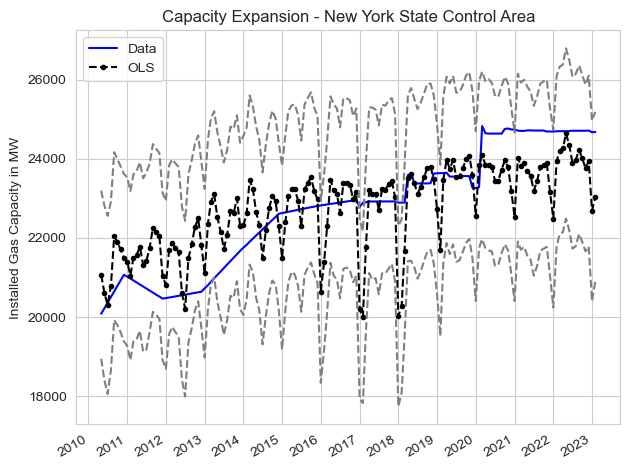

In [193]:
res_nyca = model_nyca
x_nyca = nyca_df.index
y_true_nyca = nyca_df['Gas (NYCA)']
y = predictions_nyca

prstd, iv_l, iv_u = wls_prediction_std(res_nyca)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x_nyca, y_true_nyca, 'b-', label="Data")
ax.plot(x_nyca, res_nyca.fittedvalues, color='black', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x_nyca, iv_u, color='tab:gray', linestyle='--')
ax.plot(x_nyca, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
#ax.set_ylim(22000, 24500)
ax.set_title('Capacity Expansion - New York State Control Area')
ax.set_ylabel('Installed Gas Capacity in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [194]:
nyc_df = nyc_reg[['Gas (NYC)', 
                    #'Coal (NYC)',
                    # 'Oil (NYC)', 
                    #'Renewables (NYC)', 
                    #'Others (NYC)',
                    #'Sum (NYC)',
                    #'Sum_woGas (NYC)',
                    'nyc_icap',
                    #'natural gas', 
                    'nyc_dam', 
                    #'Cleared Above NYC (%)', 
                    #'UCAP NYC (MW)',
                    'ICAP-1', 
                    'ICAP-2', 'ICAP-3', 'ICAP-4',
                    'DAM-1', 
                    'DAM-2', 'DAM-3', 'DAM-4'
                    ]]

<Axes: >

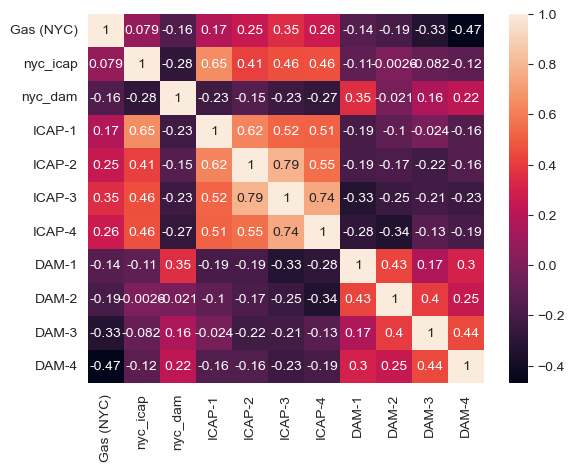

In [195]:
sns.heatmap(nyc_df.corr(), annot = True)

In [196]:
x = nyc_df.loc[:, nyc_df.columns != 'Gas (NYC)']
y = nyc_df['Gas (NYC)']

x = sm.add_constant(x)

model_nyc = sm.OLS(y, x).fit()
predictions_nyc = model_nyc.predict()

print(model_nyc.summary())

                            OLS Regression Results                            
Dep. Variable:              Gas (NYC)   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     6.200
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           9.33e-08
Time:                        10:26:55   Log-Likelihood:                -1074.2
No. Observations:                 146   AIC:                             2170.
Df Residuals:                     135   BIC:                             2203.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8973.1091    155.128     57.843      0.0

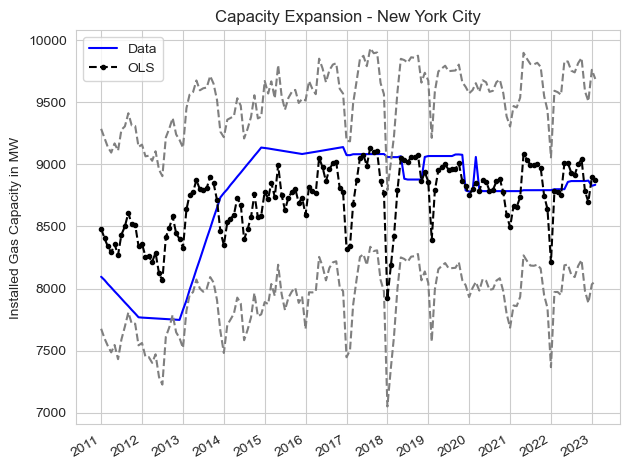

In [197]:
res_nyc = model_nyc
x_nyc = nyc_df.index
y_true_nyc = nyc_df['Gas (NYC)']
y = predictions_nyc

prstd, iv_l, iv_u = wls_prediction_std(res_nyc)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x_nyc, y_true_nyc, 'b-', label="Data")
ax.plot(x_nyc, res_nyc.fittedvalues, color='black', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x_nyc, iv_u, color='tab:gray', linestyle='--')
ax.plot(x_nyc, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
#ax.set_ylim(8500, 9500)
ax.set_title('Capacity Expansion - New York City')
ax.set_ylabel('Installed Gas Capacity in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [198]:
gj_df = gj_reg[['Gas (GJ)', 
                    #'Coal (GJ)',
                    # 'Oil (GJ)', 
                    #'Renewables (GJ)', 
                    #'Others (GJ)',
                    #'Sum (GJ)',
                    #'Sum_woGas (GJ)',
                    'gj_icap',
                    #'natural gas', 
                    'gj_dam', 
                    #'Cleared Above GJ (%)', 
                    #'UCAP GJ (MW)',
                    'ICAP-1', 
                    'ICAP-2', 
                    'ICAP-3', 
                    'ICAP-4',
                    'DAM-1', 
                    'DAM-2', 
                    'DAM-3', 'DAM-4'
                    ]]

<Axes: >

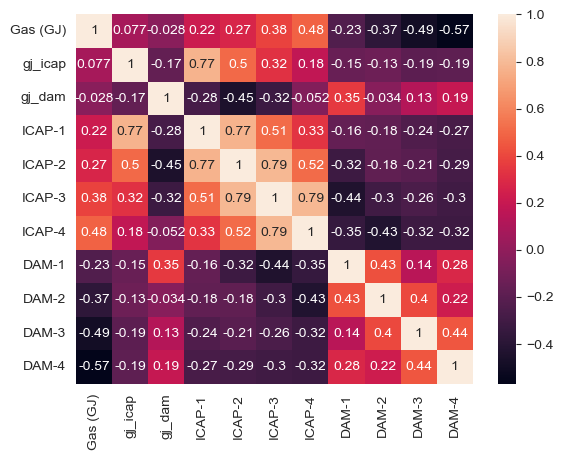

In [199]:
sns.heatmap(gj_df.corr(), annot = True)

In [200]:
x = gj_df.loc[:, gj_df.columns != 'Gas (GJ)']
y = gj_df['Gas (GJ)']

x = sm.add_constant(x)

model_gj = sm.OLS(y, x).fit()
predictions_gj = model_gj.predict()

print(model_gj.summary())

                            OLS Regression Results                            
Dep. Variable:               Gas (GJ)   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     13.27
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           5.49e-16
Time:                        10:27:00   Log-Likelihood:                -1196.9
No. Observations:                 146   AIC:                             2416.
Df Residuals:                     135   BIC:                             2449.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.484e+04    361.817     41.019      0.0

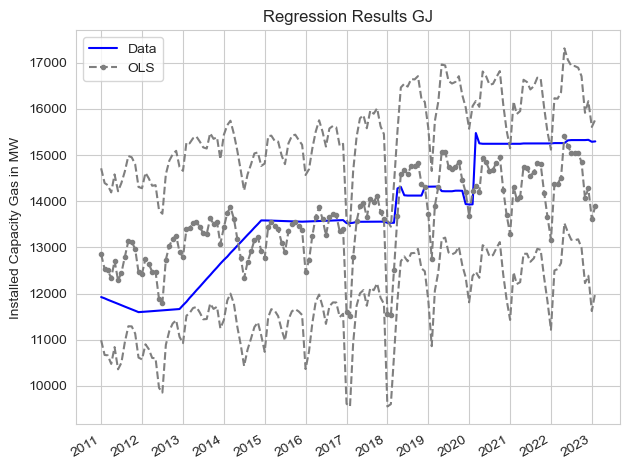

In [201]:
res_gj = model_gj
x_gj = gj_df.index
y_true_gj = gj_df['Gas (GJ)']
y = predictions_gj

prstd, iv_l, iv_u = wls_prediction_std(res_gj)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x_gj, y_true_gj, 'b-', label="Data")
ax.plot(x_gj, res_gj.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x_gj, iv_u, color='tab:gray', linestyle='--')
ax.plot(x_gj, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
#ax.set_ylim(12500, 15000)
ax.set_title('Regression Results GJ')
ax.set_ylabel('Installed Capacity Gas in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [202]:
li_df = li_reg[['Gas (LI)', 
                    #'Coal (LI)',
                    # 'Oil (LI)', 
                    #'Renewables (LI)', 
                    #'Others (LI)',
                    #'Sum (LI)',
                    #'Sum_woGas (LI)',
                    'li_icap',
                    #'natural gas', 
                    'li_dam', 
                    #'Cleared Above LI (%)', 
                    #'UCAP LI (MW)',
                    'ICAP-1', 
                    'ICAP-2', 'ICAP-3', 'ICAP-4',
                    'DAM-1', 
                    'DAM-2', 'DAM-3', 'DAM-4'
                    ]]

In [203]:
#sns.heatmap(li_df.corr(), annot = True)

In [204]:
x = li_df.loc[:, li_df.columns != 'Gas (LI)']
y = li_df['Gas (LI)']

x = sm.add_constant(x)

model_li = sm.OLS(y, x).fit()
predictions_li = model_li.predict()

print(model_li.summary())

                            OLS Regression Results                            
Dep. Variable:               Gas (LI)   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     14.29
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           5.02e-17
Time:                        10:27:02   Log-Likelihood:                -760.71
No. Observations:                 146   AIC:                             1543.
Df Residuals:                     135   BIC:                             1576.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4117.7468     15.842    259.926      0.0

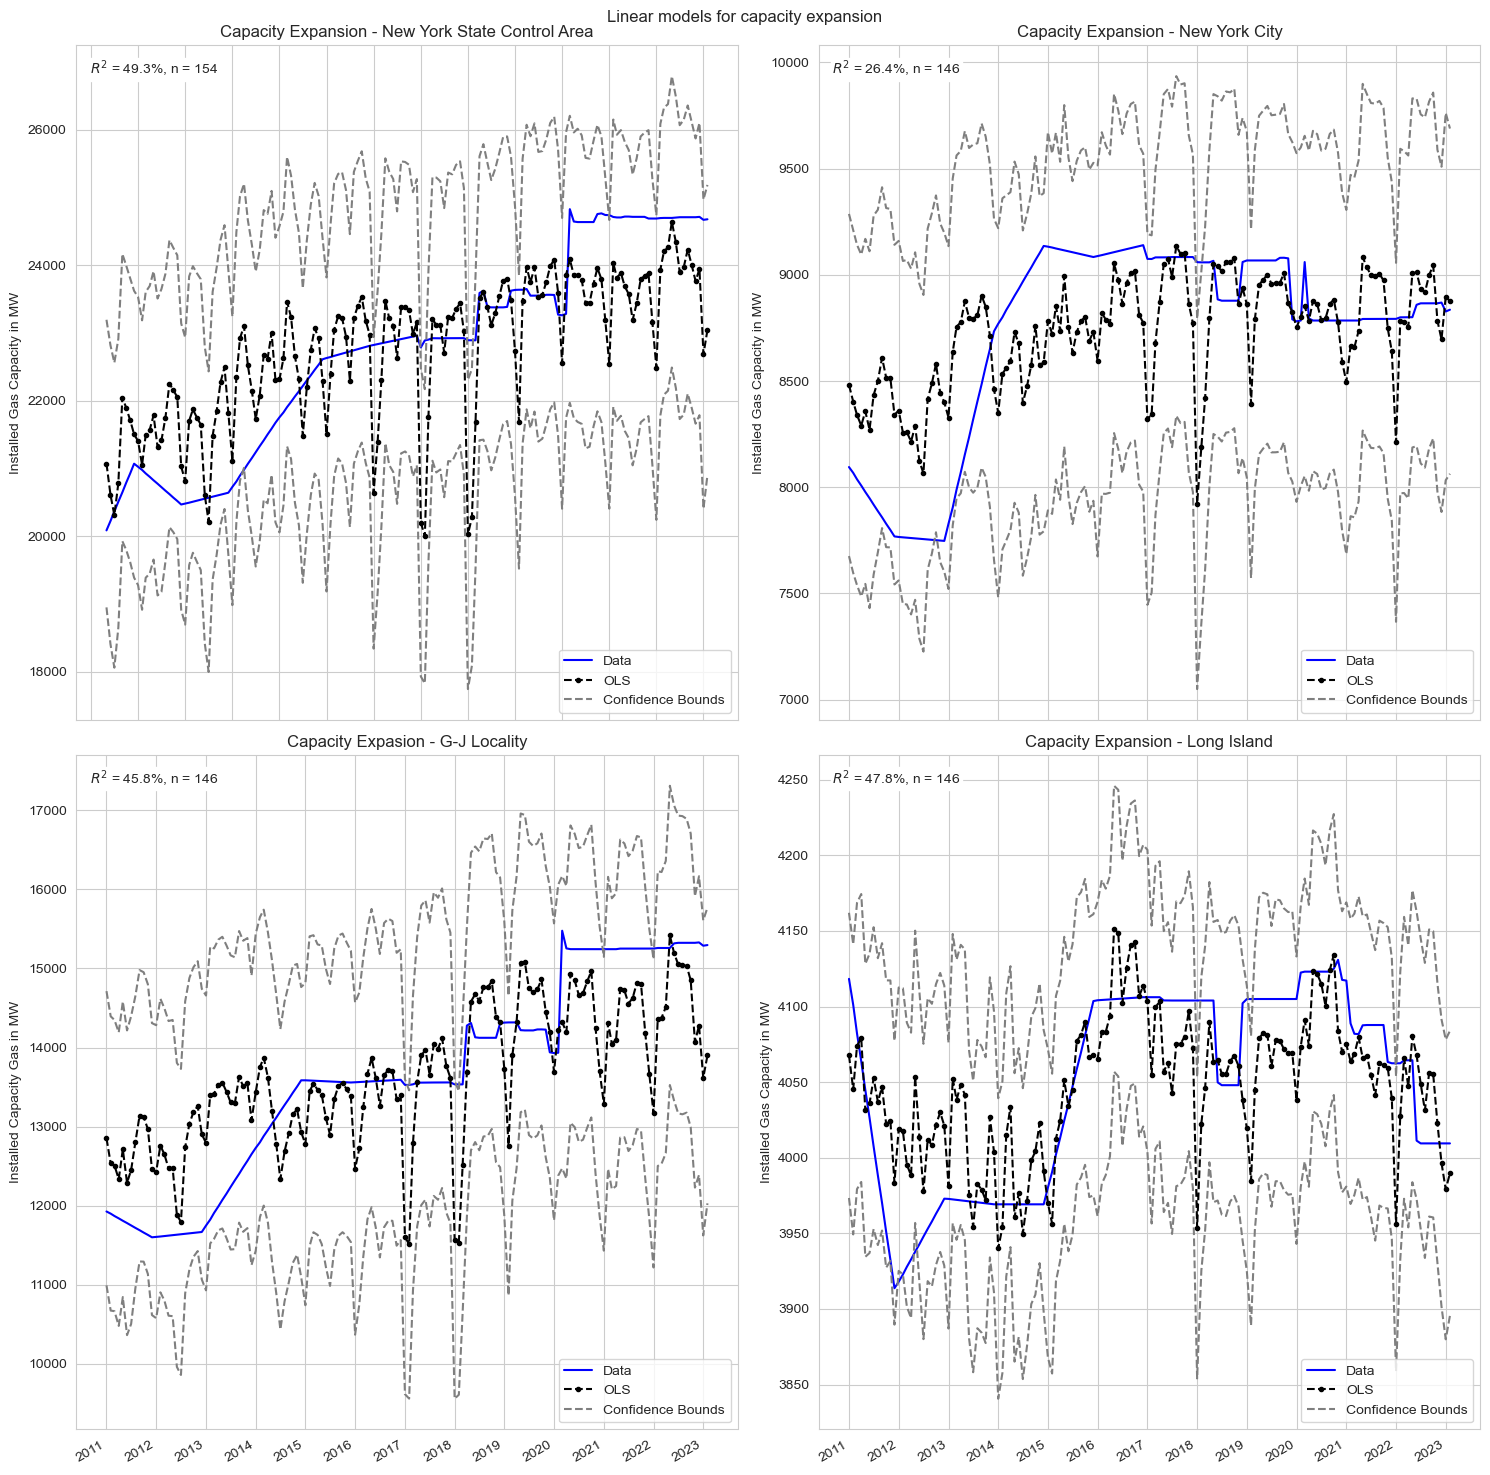

In [205]:
fig, ax = plt.subplots(2, 2, figsize = (15, 15))


# New York State Control Area subplot
res_nyca = model_nyca
x_nyca = nyca_df.index
y_true_nyca = nyca_df['Gas (NYCA)']
y = predictions_nyca
prstd, iv_l, iv_u = wls_prediction_std(res_nyca)


ax[0, 0].plot(x_nyca, y_true_nyca, 'b-', label="Data")
ax[0, 0].plot(x_nyca, res_nyca.fittedvalues, color='black', marker='.', linestyle='--', label="OLS") #--.
ax[0, 0].plot(x_nyca, iv_u, color='tab:gray', linestyle='--', label="Confidence Bounds")
ax[0, 0].plot(x_nyca, iv_l, color='tab:gray', linestyle='--')
ax[0, 0].legend(loc='lower right')
#ax.set_ylim(22000, 24500)
ax[0, 0].set_title('Capacity Expansion - New York State Control Area')
ax[0, 0].set_ylabel('Installed Gas Capacity in MW')

ax[0, 0].text(0.02, 0.98, "$R^2$ = 49.3%, n = 154",
               ha = 'left', va = 'top',
               transform=ax[0, 0].transAxes,
               bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1}
               )

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax[0, 0].xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax[0, 0].xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels



# New York City subplot
res_nyc = model_nyc
x_nyc = nyc_df.index
y_true_nyc = nyc_df['Gas (NYC)']
y = predictions_nyc
prstd, iv_l, iv_u = wls_prediction_std(res_nyc)


ax[0, 1].plot(x_nyc, y_true_nyc, 'b-', label="Data")
ax[0, 1].plot(x_nyc, res_nyc.fittedvalues, color='black', marker='.', linestyle='--', label="OLS") #--.
ax[0, 1].plot(x_nyc, iv_u, color='tab:gray', linestyle='--', label="Confidence Bounds")
ax[0, 1].plot(x_nyc, iv_l, color='tab:gray', linestyle='--')
ax[0, 1].legend(loc='lower right')
#ax.set_ylim(8500, 9500)
ax[0, 1].set_title('Capacity Expansion - New York City')
ax[0, 1].set_ylabel('Installed Gas Capacity in MW')

ax[0, 1].text(0.02, 0.98, "$R^2$ = 26.4%, n = 146",
               ha = 'left', va = 'top',
               transform=ax[0, 1].transAxes,
               bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1}
               )

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax[0, 1].xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax[0, 1].xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels



# Hudson Valley subplot
res_gj = model_gj
x_gj = gj_df.index
y_true_gj = gj_df['Gas (GJ)']
y = predictions_gj
prstd, iv_l, iv_u = wls_prediction_std(res_gj)


ax[1, 0].plot(x_gj, y_true_gj, 'b-', label="Data")
ax[1, 0].plot(x_gj, res_gj.fittedvalues, color='black', marker='.', linestyle='--', label="OLS") #--.
ax[1, 0].plot(x_gj, iv_u, color='tab:gray', linestyle='--', label="Confidence Bounds")
ax[1, 0].plot(x_gj, iv_l, color='tab:gray', linestyle='--')
ax[1, 0].legend(loc='lower right')
#ax.set_ylim(12500, 15000)
ax[1, 0].set_title('Capacity Expasion - G-J Locality')
ax[1, 0].set_ylabel('Installed Capacity Gas in MW')

ax[1, 0].text(0.02, 0.98, "$R^2$ = 45.8%, n = 146",
               ha = 'left', va = 'top',
               transform=ax[1, 0].transAxes,
               bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1}
               )

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax[1, 0].xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax[1, 0].xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels



# Long Island subplot
res_li = model_li
x_li = li_df.index
y_true_li = li_df['Gas (LI)']
y_li = predictions_li
prstd, iv_l, iv_u = wls_prediction_std(res_li)


ax[1, 1].plot(x_li, y_true_li, 'b-', label="Data")
ax[1, 1].plot(x_li, res_li.fittedvalues, color='black', marker='.', linestyle='--', label="OLS") #--.
ax[1, 1].plot(x_li, iv_u, color='tab:gray', linestyle='--', label="Confidence Bounds")
ax[1, 1].plot(x_li, iv_l, color='tab:gray', linestyle='--')
ax[1, 1].legend(loc='lower right')
#ax.set_ylim(3900, 4200)
ax[1, 1].set_title('Capacity Expansion - Long Island')
ax[1, 1].set_ylabel('Installed Gas Capacity in MW')

ax[1, 1].text(0.02, 0.98, "$R^2$ = 47.8%, n = 146",
               ha = 'left', va = 'top',
               transform=ax[1, 1].transAxes,
               bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1}
               )

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax[1, 1].xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax[1, 1].xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels

fig.suptitle("Linear models for capacity expansion")
plt.tight_layout()
plt.show()